# Tutorial 3 - Interventions

- [Go back to **Tutorial 2: Handling PyRossGeo output**](../tutorial2-handling-PyRossGeo-output/tutorial2-handling-PyRossGeo-output.ipynb)
- [Skip to **Tutorial 4: Making visualisations using GeoPandas**](../tutorial4-making-visualisations-with-geopandas/tutorial4-making-visualisations-with-geopandas.ipynb)
- [Go to the PyRossGeo documentation](https://github.com/lukastk/PyRossGeo/blob/master/docs/documentation.md)

<b>Note: The various model parameters used in this tutorial were chosen for illustrative purposes, and are not based on figures from medical literature. Therefore the results of the simulations in the tutorial are not indicative of reality.</b>

In this tutorial we will learn how to model a lock-down using *events*. We will be using the same SEAIR network defined in Tutorial 2.

In [1]:
%%capture
# Compile and import local pyrossgeo module
import os, sys
owd = os.getcwd()
os.chdir('../../')
sys.path.insert(0,'../../')
!python setup.py build_ext --inplace
os.chdir(owd)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyrossgeo

import pandas as pd
import json

## 3.1 Events

In PyRossGeo, an *event* is a time-triggered call to a function that the user provides. It is very easy to use. All that's needed is to define the event function, and the times at which the event should be triggered. See the example below:

In [2]:
hello_times = [ 100*(24*60), 200*(24*60), 300*(24*60) ]

def hello_world(sim, step_i, t, dt, X_state, dX_state, X_state_saved, ts_saved, save_i): 
    print("Hello World. Day %s." % int(t/(24*60)))

Here we have define a list `hello_times`, which contains the three event-trigger times: day 100, 200 and 300 of the simulation (in units of minutes). We have also defined our event function `hello_world`.

We now run the simulation, passing the optional arguments `event_times` and `event_function` to `pyrossgeo.Simulation.simulate`:

In [3]:
ts, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  2*60),    
    (7*60,  1),    
    (9*60, 2*60),  
    (17*60, 1),     
    (19*60, 2*60)  
], end_time=24*60)

t_start = 0
t_end = 24*60*400 # Run for 400 days

sim = pyrossgeo.Simulation()
X_state = sim.initialize(sim_config_path='SEAIR_network')

sim_data = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=1,
                       event_times=hello_times, event_function=hello_world)

Hello World. Day 100.
Hello World. Day 200.
Hello World. Day 300.


Note that the event is called at specific *times* rather than specific *simulation steps*. This means that the times in `event_times` might not necessarily correspond to an exact simulaton step. For example, we could write `say_the_day_times = [ 100*(24*60) + 0.5 ]`. If that's the case, then PyRossGeo will automatically round the time up to the nearest corresponding simululation step.

Let's look at the arguments of the event function:

```python
def hello_world(sim, step_i, t, dt, X_state, dX_state, X_state_saved, ts_saved, save_i):
```

- `sim` is the same `pyrossgeo.Simulation` instance that you are running the simulation with. It has various helper functions with which we can manipulate the state of the network with. It also has a few exposed fields that you can fiddle with at your own risk. Some of these will be introduced in this tutorial, but for the rest see [Simulation.pxd](../../pyrossgeo/Simulation.pxd) and [Simulation.pyx](../../pyrossgeo/Simulation.pyx).
- `step_i` is the current number of Forward-Euler steps the simulation has taken.
- `t` is the current time in minutes.
- `dt` is the current time step being used in the Forward-Euler integration.
- `X_state` is the current state vector of the simulation. We can use `sim.node_mappings` and `sim.cnode_mappings` to manipulate specific nodes.
- `dX_state` the current Forward-Euler derivative vector.
- `X_state_saved` is the saved frames of the simulation thus far. Note that future saved frames of the simulation will be blank in the array.
- `ts_saved` the times of each saved simulation frame.
- `save_i` the index of the latest saved frame.

If `steps_per_save` is not specified in `pyrossgeo.Simulation.simulate`, then the last three arguments will not be passed to the event function.

## 3.2 Imposing and releasing lockdowns

We will now use events to impose a lockdown on the simulation. Let us first run it without any events, for reference.

In [4]:
ts, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  2*60),    
    (7*60,  1),    
    (9*60, 2*60),  
    (17*60, 1),     
    (19*60, 2*60)  
], end_time=24*60)

t_start = 0
t_end = 24*60*100 # Run for 400 days

sim = pyrossgeo.Simulation()
X_state = sim.initialize(sim_config_path='SEAIR_network')

sim_data_no_lockdown = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=1)
ts_saved, node_data, cnode_data, location_data, community_data, network_data = pyrossgeo.utils.extract_simulation_data(sim_data_no_lockdown)

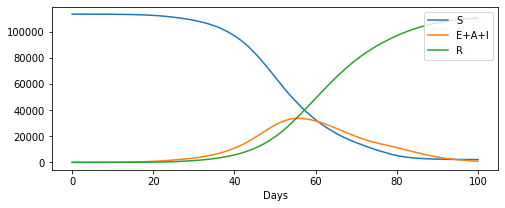

In [15]:
# Plot the evolution of the network as a whole

network_data = pyrossgeo.utils.extract_network_data(sim_data_no_lockdown)
ts_saved = pyrossgeo.utils.extract_ts(sim_data_no_lockdown)

plt.figure( figsize=(8,3) )
ts_days = ts_saved / (24*60)

S = np.sum(network_data[:,:,0], axis=1) # Sum over all age-groups
E = np.sum(network_data[:,:,1], axis=1)
A = np.sum(network_data[:,:,2], axis=1)
I = np.sum(network_data[:,:,3], axis=1)
R = np.sum(network_data[:,:,4], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, E+A+I, label="E+A+I")
plt.plot(ts_days, R, label="R")

plt.legend(loc='upper right', fontsize=10)
plt.xlabel('Days')
plt.show()

We will now define our lockdown event:

In [6]:
lockdown_day = 40
release_day = 100
lockdown_and_release_times = [ lockdown_day*(24*60), release_day*(24*60) ]

old_C_home = None

def lockdown_and_release(sim, step_i, t, dt, X_state, dX_state, X_state_saved, ts_saved, save_i): 
    global old_C_home
    
    if not sim.is_commuting_stopped():
        print("Day %s: Imposing lockdown." % int(t / (24*60)))
        cmat = sim.get_contact_matrix('C_home')
        old_C_home = np.array(cmat)
        cmat[:] = cmat/2
        sim.stop_commuting(True)
    else:
        print("Day %s: Releasing lockdown." % int(t / (24*60)))
        cmat = sim.get_contact_matrix('C_home')
        cmat[:] = old_C_home
        sim.stop_commuting(False)

There are two ways in which we model lockdown, we stop people from commuting, and we reduce the `C_home` contact matrix.

- If you look at `SEAIR_network/node_cmatrices.csv` and `SEAIR_network/cnode_cmatrices.csv`, you will notice that when people are away from home, they interact via the `C_work` contact matrix. By turning off commuting, we remove the work contacts and prevent any spreading of the virus across the various locations.
   - Commuting can be turned off using the helper function `pyrossgeo.Simulation.stop_commuting`.
   - We can check whether we have already turned off commuting or not using `pyrossgeo.Simulation.is_commuting_stopped`.

- We reduce the `C_home` contact matrix by first getting access to it via `sim.get_contact_matrix`. We can then simply edit the array in place to change the contact structure. We store the old value of `C_home` so that we can restore its value after the release of the lockdown.

Let's run the simulation now, with our lockdown event.

In [7]:
ts, dts = pyrossgeo.utils.get_dt_schedule([
    (0,  2*60),    
    (7*60,  1),    
    (9*60, 2*60),  
    (17*60, 1),     
    (19*60, 2*60)  
], end_time=24*60)

t_start = 0
t_end = 24*60*150 # Run for 400 days

sim = pyrossgeo.Simulation()
X_state = sim.initialize(sim_config_path='SEAIR_network')

sim_data_lockdown = sim.simulate(X_state, t_start, t_end, dts, steps_per_save=1,
                       event_times=lockdown_and_release_times, event_function=lockdown_and_release)

Day 40: Imposing lockdown.
Day 100: Releasing lockdown.


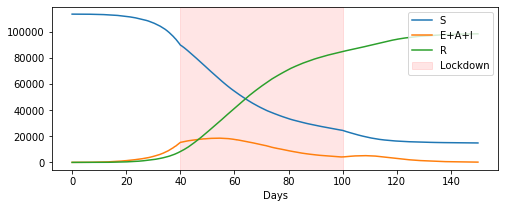

In [8]:
# Plot the evolution of the network as a whole

network_data = pyrossgeo.utils.extract_network_data(sim_data_lockdown)
ts_saved = pyrossgeo.utils.extract_ts(sim_data_lockdown)

plt.figure( figsize=(8,3) )
ts_days = ts_saved / (24*60)

S = np.sum(network_data[:,:,0], axis=1) # Sum over all age-groups
E = np.sum(network_data[:,:,1], axis=1)
A = np.sum(network_data[:,:,2], axis=1)
I = np.sum(network_data[:,:,3], axis=1)
R = np.sum(network_data[:,:,4], axis=1)

plt.plot(ts_days, S, label="S")
plt.plot(ts_days, E+A+I, label="E+A+I")
plt.plot(ts_days, R, label="R")

plt.axvspan(lockdown_day, release_day, color='red', alpha=0.1, label='Lockdown')

plt.legend(loc='upper right', fontsize=10)
plt.xlabel('Days')
plt.show()

This concludes the third part of the PyRossGeo tutorial.

- [Go back to **Tutorial 2: Handling PyRossGeo output**](../tutorial2-handling-PyRossGeo-output/tutorial2-handling-PyRossGeo-output.ipynb)
- [Continue to **Tutorial 4: Making visualisations using GeoPandas**](../tutorial4-making-visualisations-with-geopandas/tutorial4-making-visualisations-using-geopandas.ipynb)
- [Go to the PyRossGeo documentation](https://github.com/lukastk/PyRossGeo/blob/master/docs/documentation.md)